# UK Road Safety: Traffic Accidents and Vehicles - Model Training
## Detailed dataset of road accidents and involved vehicles in the UK (2005-2016)
Source:
<u>https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles#Accident_Information.csv </u>
    



# Standard imports
+useful figure save function

In [1]:
# The code was removed by Watson Studio for sharing.

In [3]:
import random as rnd
import numpy as np
import pandas as pd
import sys
import datetime
from matplotlib import pyplot as plt
from collections import Counter
import logging
import time
import math


#prevents intrusive spark debug notificaitions
logging.getLogger("py4j").setLevel(logging.ERROR)
plt.style.use('seaborn-whitegrid')
cmap=plt.get_cmap('Pastel2')
#cmap=plt.get_cmap('tab20c')

mypath_ = !pwd

def save_fig(fig_id, fig_txt, tight_layout=True, fig_extension="png", resolution=300):
    #generic function to save images to file
    filename =  mypath_[0]+'/img/' + fig_txt + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    fig_id.savefig(filename, format=fig_extension, dpi=resolution, bbox_inches='tight')
    file_data=open(filename, 'rb')
    project.save_data(data=file_data.read(),file_name=fig_txt+'.png',overwrite=True)
    file_data.close() 


# Load data from Parquet files
Load the previously transformed dataset<br>
Allow for loading a sample for testing

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

rdd_accidents = spark.read.load("accidents_tr.parquet")

#Uncomment to select subset of the data
######################## UNCOMMENT FOR TESTING ##########################
#rdd_accidents = rdd_accidents.sample(withReplacement=False, fraction=0.1)
#########################################################################


rdd_accidents.head()
rdd_accidents.createOrReplaceTempView("accidents")
rdd_accidents.printSchema()
print("number of records: {:d}".format(rdd_accidents.count()))


root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Local_Authority_Highway: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Number_

## Load Packages

In [5]:
from pyspark.sql import functions as F 
from pyspark.sql.functions import *
from pyspark.sql.functions import col, isnan, when, trim
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, IndexToString, VectorIndexer
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import Evaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics

rnd_seed=42 #for reproductibility

# Use case: predict accident severity at each output area (LSOA) given datetime and driving conditions
<br>
<em>Given date, time, weather, light and road conditions, predict accident severity within the operating geographic area of a police force</em> <br>
<br>

## Loading and encoding functions

<b>The main takeaway is that the raw data is aggregated according to each categorical data, <br>
then counts of 'Slight' and 'Serious' accidents are performed as well as the ratio of 'Serious'/('Slight'+'Serious').<br>
This ratio ('Severety_Pct) is our reponse variable. The machine learning task is therefore a regression model to predict this ratio.<br>
Later on we aggregate this informatio at LSOA level - to be displayed on a map on the final deliverable</b>

In [6]:
#some global variables

retained_features=[
    'Accident_Severity',
    'LSOA_of_Accident_Location',
    'Police_Force',
    'Latitude',
    'Longitude',
    'Weather_Conditions',
    'Light_Conditions',
    'Road_Surface_Conditions',
    'Day_of_Week',
    'Hour',
    'Week',
    'Peak_or_OffPeak',
    'Centroid_Latitude',
    'Centroid_Longitude']

features={
    'response':'Accident_Severity',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak']}

data_group={
    'name': "Police_Force",
    'item': "City of London"}



def to_null(c):
        #function to discard NUL NA and empty records
        from pyspark.sql.functions import col, isnan, when, trim
        return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))
    

    
def load_data(group=data_group, feats=retained_features):
#load data from one group into RDD selecting only retained features and create view
    sql_query= '''SELECT {} FROM {} WHERE {}={}'''
    try:
        if group['name']=='All':
            rdd_data = spark.sql("SELECT {} from accidents".format(', '.join(feats)))
        else:
            rdd_data = spark.sql(sql_query.format(', '.join(feats), "accidents", group['name'], "'"+group['item']+"'"))
        #remove any null or empty entries
        rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
        #print(rdd_data.head())
        rdd_data.createOrReplaceTempView("data")
        nb_slight  = spark.sql("SELECT COUNT(Accident_Severity) FROM data WHERE Accident_Severity='Slight'").collect()[0][0]
        nb_severe  = spark.sql("SELECT COUNT(Accident_Severity) FROM data WHERE Accident_Severity='Serious'").collect()[0][0]
        print("nb Slight:{:d}, nb Serious:{:d}, %Slight: {:.1f}%".format(nb_slight, nb_severe, 100*nb_slight/(nb_slight+nb_severe)))
        return rdd_data
    except:
        print("{} not found in {}".format(group['item'], group['name']))
        return None      
                 
             
def summarize_data_by_lsoa(rdd_data, feats = retained_features[1:]):
    #summarize data by output area
    rdd_data.createOrReplaceTempView("data")
    severe_col = 'Accident_Severity'
    acc_type = "Slight"
    lsoa = 'LSOA_of_Accident_Location'
    sql_query = '''
        SELECT {0},
        COUNT(CASE WHEN {1}  = '{2}' THEN {3} END) AS Slight, 
        COUNT(CASE WHEN {1} != '{2}' THEN {3} END) AS Serious 
        FROM {4} GROUP BY {5}'''
    feats = feats + ([lsoa] if lsoa not in feats else [])
    new_rdd = spark.sql(sql_query.format(', '.join(feats), severe_col, acc_type, severe_col, "data", ', '.join(feats)))
    new_rdd = new_rdd.withColumn('Severity_Pct', (new_rdd['Serious']/(new_rdd['Slight']+new_rdd['Serious'])).cast('double'))
    try:
        new_rdd.select([to_null(c).alias(c) for c in new_rdd.columns]).na.drop()
    except:
        print("Standard NA.drop only")
        new_rdd.na.drop()
    return new_rdd


def load_rdd_data_and_string_encode(group=data_group, features=features):
    #Load data and string-encode all categorical variables
    rdd_data = load_data(group=group)
    rdd_data, columns_index = string_encode(rdd_data, features['cat_pred'])
    new_features={}
    new_features['cat_pred'] = columns_index[:-1]
    new_features['response'] = columns_index[-1]
    return rdd_data, new_features

def load_and_split_data(group=data_group, features=features):
    #generic load and split
    rdd_data, new_features = load_rdd_data(group, features)
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    return rdd_train, rdd_test, new_features


def load_and_split_data_with_centroids(group=data_group, features=features):
    #load add centroid data and split (no longer needed in next iteration)
    rdd_data, new_features = load_rdd_data(group, features)
    lsoa_data = spark.sql("SELECT LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,\
          PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, PERCENTILE(Longitude, 0.5) AS Centroid_Longitude \
          FROM accidents GROUP BY LSOA_of_Accident_Location")
    rdd_data = rdd_data.join(lsoa_data, rdd_data.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
    .drop(lsoa_data.LSOA_of_Accident_Location).drop(lsoa_data.Accident_Count)
    #remove null values
    rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
    #add centroids in feature list
    new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    #remove LSOA_of_Accident_Location from feature list
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    return rdd_train, rdd_test, new_features

    
    
def string_encode(rdd_data, columns):
    #string encode categorical variables using a list of stacked pipelines
    # fit over the whole dataset for consistency
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(rdd_accidents) for column in columns]
    index_pipeline = Pipeline(stages=indexers)
    columns_index = [x+'_index' for x in columns]
    return index_pipeline.fit(rdd_data).transform(rdd_data), columns_index


def cyc_encode(rdd_data, columns, period):
    #encode cyclical variables like hour or week using sin/cos 
    #(not used after only considering peak/off_peak hours given data sparsity)
    from math import pi
    for i, column in enumerate(columns):
        udf_sin = udf(lambda x: math.sin(2.0*pi*float(x)/period[i]), DoubleType())
        udf_cos = udf(lambda x: math.cos(2.0*pi*float(x)/period[i]), DoubleType())
        rdd_data = rdd_data.withColumn("sin_"+column, udf_sin(col))
        rdd_data = rdd_data.withColumn("cos_"+column, udf_cos(col))
        columns_cyc = [cyc+x for cyc in ['sin_', 'cos_'] for x in columns]
    return rdd_data, columns_cyc    
        
    


<b> Calculate aggregated Police force data with computed GPS centroids <br>
This allows us to see the size of the data for each police force.<br></b>

In [7]:

sql_query = '''
    SELECT 
    Police_Force, 
    COUNT(Police_Force) As Accident_Count, 
    COUNT(DISTINCT(LSOA_of_Accident_Location)) AS Nb_of_LSOAS, 
    COUNT(Police_Force)/COUNT(DISTINCT(LSOA_of_Accident_Location)) AS Avge_Acc_per_LSOA,
    PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, 
    PERCENTILE(Longitude, 0.5) AS Centroid_Longitude 
    FROM accidents GROUP BY Police_Force'''

police_force_data = spark.sql(sql_query)
p_list = list(police_force_data.filter(police_force_data.Nb_of_LSOAS > 2).toPandas()['Police_Force'].values)
police_force_data.toPandas()

,Police_Force,Accident_Count,Nb_of_LSOAS,Avge_Acc_per_LSOA,Centroid_Latitude,Centroid_Longitude
0,Thames Valley,70832,1469,48.217835,51.630713,-0.845010
1,Gwent,9794,380,25.773684,51.639377,-3.034203
2,Hampshire,58687,1259,46.613979,50.911118,-1.211942
3,Staffordshire,38431,711,54.052039,52.843315,-2.105602
4,Gloucestershire,14476,378,38.296296,51.856355,-2.199352
5,Nottinghamshire,35942,718,50.058496,53.001888,-1.155156
6,North Yorkshire,26844,502,53.474104,54.018132,-1.217075
7,Surrey,48852,746,65.485255,51.305362,-0.472989
8,Cumbria,17363,324,53.589506,54.566457,-2.993077
9,Cleveland,12183,385,31.644156,54.570228,-1.236459


# Gradient Boosted Trees Model with GPS centroid features

In [11]:
def load_and_split_summary_data(group=data_group, features=features):
    #load data and split into train/test rdds to be consumed by the gbt models
    start_time = time.time()
    rdd_data = load_data(group=group)
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    rdd_train = summarize_data_by_lsoa(rdd_train, feats = features['cat_pred'])
    rdd_test = summarize_data_by_lsoa(rdd_test, feats = features['cat_pred'])
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_train, rdd_test, new_features


def create_and_train_gbt_model(features=features):
    #instantiate pipeline and train the model
    #categorical data is simply converted into indexes - the gbt models does not need one-hot encoding 
    start_time = time.time()
    new_features = {}
    new_features['response'] = features['response']
    #string_encode categorical data using a list of indexers, one for each categorical data
    #ensureing the encoding is done on train+test set to have consistent encoding accross both sets
    rdd_data = rdd_train.unionAll(rdd_test)
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(rdd_accidents) for column in features['cat_pred']]
    new_features['cat_pred'] = [x+'_index' for x in features['cat_pred']]
    #Vectorise the inputs
    vectorAssembler = VectorAssembler(inputCols=new_features['cat_pred'], outputCol="features")
    #Instatiate classifier
    gbt = GBTRegressor(labelCol=new_features['response'], featuresCol="features",
                        maxIter=30, maxDepth=6, maxBins=100)
    #Create pipeline
    pipeline = Pipeline(stages=indexers + [vectorAssembler, gbt])
    #Fit Model
    model_gbt = pipeline.fit(rdd_train)
    print("training completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return new_features, pipeline, model_gbt


# Custom evaluator based on rmse on aggregated data
class agg_evaluator(Evaluator):

    def __init__(self, predictionCol="prediction", labelCol="label", verbose=False):
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.verbose=verbose

    def _evaluate(self, dataset):
        df = dataset.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])\
                [self.labelCol, self.predictionCol].mean().reset_index()
        rmse = ((df[self.predictionCol] - df[self.labelCol]) ** 2).mean() ** .5
        if self.verbose:
            print("rmse={:.3f}".format(rmse))
        return rmse

    def isLargerBetter(self):
        return False




def evaluate_reg_model(model, rdd, set_name, response=features["response"]):
    #Calculate root mean squared error as a performance measures
    print("evaluation start...")
    start_time = time.time()    
    pred_test = model.transform(rdd)
    #evaluator = RegressionEvaluator(labelCol=response, predictionCol="prediction", metricName="rmse")
    #rmse = evaluator.evaluate(predY)
    pred_val = pred_test.rdd.map(lambda row: (float(row['prediction']), float(row['Severity_Pct'])))
    metrics = RegressionMetrics(pred_val)
    #metrics = RegressionMetrics
    print("Root Mean Squared Error (RMSE) on {} data = {:.2f}".format(set_name, metrics.rootMeanSquaredError)) 
    print("R2 (explained variance ratio) on {} data = {:.2f}".format(set_name, metrics.r2)) 
    print("evaluation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return pred_test, metrics.rootMeanSquaredError, metrics.r2




def display_results_graphs(pred_train, pred_test):
    #Display the actual Sererity_Pct for each instance (sorted by increasing order) and compare to predictions
    #for both the train and test set
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    df1 = pred_train.toPandas().sort_values('Severity_Pct')
    df1.plot(y='Severity_Pct', ax=ax1, use_index=False, c='k', linewidth=2)
    df1.plot(y='prediction', ax=ax1, use_index=False, c='b', alpha=0.7)
    ax1.set_title("Train set", fontweight='bold')
    ax1.set_ylim(-.1, 1.2)
    ax1.set_xlabel("summary instance")
    ax1.set_ylabel("severity ratio")
    df2 = pred_test.toPandas().sort_values('Severity_Pct')
    df2.plot(y='Severity_Pct', ax=ax2, use_index=False, c='k', linewidth=2)
    df2.plot(y='prediction', ax=ax2, use_index=False,c='r', alpha=0.7)
    ax2.set_title("Test set", fontweight='bold')
    ax2.set_ylim(-.1, 1.2)
    ax2.set_xlabel("summary instance")
    ax2.set_ylabel("severity ratio")    
    print("train set size={:d}, test set size={:d}".format(len(df1), len(df2)))
    return fig


def display_agg_results_graphs(pred_train, pred_test):
    #Display the actual Sererity_Pct for each instance (sorted by increasing order) and compare to predictions
    #for both the train and test set
    #But this time AGGREGATED by LSOA - this will be the actual deliverable 
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    try:
        df1 = pred_train.toPandas().groupby(['LSOA_of_Accident_Location'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
        df2 = pred_test.toPandas().groupby(['LSOA_of_Accident_Location'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
    except:
        #normalised dataset
        df1 = pred_train.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
        df2 = pred_test.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
    bars = ax1.plot(range(len(df1)),df1.prediction, color='b', alpha=0.5, label='prediction')
    bars = ax1.step(range(len(df1)),df1.Severity_Pct, color='k', lw=1, label='actual')
    ax1.xaxis.grid(False)
    #ax1.set_xticks([])
    ax1.set_ylim(-.1, 1.2)
    ax1.set_xlabel("Summary instances aggregated by LSOA")
    ax1.set_ylabel("Avge severity ratio")
    ax1.set_title("Train set", fontweight='bold')
    l=ax1.legend()
    bars = ax2.plot(range(len(df2)),df2.prediction, color='r', alpha=0.5, label='prediction')
    bars = ax2.step(range(len(df2)),df2.Severity_Pct, color='k', lw=1, label='actual')
    ax2.xaxis.grid(False)
    #ax2.set_xticks([])
    ax2.set_ylim(-.1, 1.2)
    ax2.set_xlabel("Summary instances aggregated by LSOA")
    ax2.set_ylabel("Avge severity ratio")
    l=ax2.legend()
    ax2.set_title("Test set", fontweight='bold')
    return fig


In [14]:
def one_hot_encode(rdd_data, columns):
    #one_hot_encode categorical variables
    for column in columns:
        try:
            rdd_data = OneHotEncoder(inputCol=column, outputCol=column+"_vec").transform(rdd_data)
        except:
            print("One_hot encoding already performed for ", column)
    columns_vec = [x+'_vec' for x in columns]
    return rdd_data, columns_vec


def load_one_hot_and_split_data_with_centroids(group=data_group, features=features):
    #Because of the vectorisation of features required by spark ML,
    #we have to either normalise all features or none 
    #This means that we now have to explicitly one-hot encode the categorical features
    #The encoding has to be done before the train/test split to ensure that it is consistent across both sets
    #The fianl step is aggregating the data by lsoa and compute our response feature
    print("loading and formatting data...")
    start_time = time.time()
    rdd_data = load_data(group=group)
    rdd_data.cache()
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    #remove null values
    rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
    #add centroids in feature list
    new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    #remove LSOA_of_Accident_Location from feature list
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    #one_one encode categorical data
    rdd_data, new_features['cat_pred'] = string_encode(rdd_data, new_features['cat_pred'])
    rdd_data, new_features['cat_pred_vec'] = one_hot_encode(rdd_data, new_features['cat_pred'])
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    rdd_data.unpersist()
    rdd_train.cache()
    rdd_test.cache()
    rdd_train = summarize_data_by_lsoa(rdd_train, feats = new_features['cat_pred_vec']+new_features['ord_pred'])
    rdd_test = summarize_data_by_lsoa(rdd_test, feats = new_features['cat_pred_vec']+new_features['ord_pred'])
    print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_train, rdd_test, new_features



def create_and_train_gbt_model_normalised(rdd_train, gbt_params, features=features):
    #instantiate pipeline and train the model
    print("training start...")
    start_time = time.time()
    new_features = features
    #Vectorise the inputs
    vectorAssembler = VectorAssembler(inputCols=new_features['cat_pred_vec']+new_features['ord_pred'], outputCol="features")
    #Normalise all features
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    #Instatiate classifier
    gbt = GBTRegressor(labelCol=new_features['response'], featuresCol="scaledFeatures",
                        maxIter=gbt_params['maxIter'], maxDepth=gbt_params['maxDepth'], maxBins=gbt_params['maxBins'])
    #Create pipeline
    pipeline = Pipeline(stages=[vectorAssembler, scaler, gbt])
    #Fit Model
    model_gbt = pipeline.fit(rdd_train)
    print("training completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return pipeline, model_gbt



def train_model(police_force, gbt_params, display_graph=False, cross_validated=False, save_figure=False):
    features={
    'response':'Severity_Pct',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak'],\
    'ord_pred':['Centroid_Latitude', 'Centroid_Longitude']}
    
    data_group={
    'name': "Police_Force",
    'item': police_force}
    print("=====>Analysing {} police force data".format(data_group['item'].replace(' ','_')))
    rdd_train_norm, rdd_test_norm, ml_feats= load_one_hot_and_split_data_with_centroids(data_group, features)
    rdd_train_norm.cache()
    pipeline_norm, model_gbt_norm = create_and_train_gbt_model_normalised(rdd_train_norm, gbt_params, ml_feats)
    if cross_validated:
        print("cross-validation start...")
        start_time = time.time()
        paramGrid = ParamGridBuilder().build()
        evaluator = RegressionEvaluator(labelCol=response, predictionCol="prediction", metricName="rmse") 
        #evaluator = agg_evaluator(labelCol=response, predictionCol="prediction", metricName="rmse") 
        cv_model = CrossValidator(estimator=pipeline_norm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
        model_gbt_norm = cv_model.fit(rdd_train_norm)
        print("cross-validation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    pred_train_norm, _, _  = evaluate_reg_model(model_gbt_norm, rdd_train_norm, "train", response=ml_feats["response"])
    rdd_train_norm.unpersist()
    rdd_test_norm.cache()
    pred_test_norm, _, _  = evaluate_reg_model(model_gbt_norm, rdd_test_norm, "test", response=ml_feats["response"])
    if display_graph:
        fig = display_results_graphs(pred_train_norm, pred_test_norm)
        if save_figure: save_fig(fig, "train_results")
        fig = display_agg_results_graphs(pred_train_norm, pred_test_norm)
        if save_figure: save_fig(fig, "train_results_agg")
    rdd_test_norm.unpersist()
    return model_gbt_norm, rdd_train_norm, rdd_test_norm

def load_trained_model(police_force):
    features={
    'response':'Severity_Pct',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
                'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak'],\
    'ord_pred':['Centroid_Latitude', 'Centroid_Longitude']}
    
    data_group={
    'name': "Police_Force",
    'item': police_force}
    f_name = police_force.replace(' ','_') + '.gbt'
    try:
        print("=====>Loading {} police force data".format(data_group['item'].replace(' ','_')))
        model = Pipeline().load('models/' + f_name)
        rdd_train, rdd_test, ml_feats= load_one_hot_and_split_data_with_centroids(data_group, features)
        return model, rdd_train, rdd_test
    except:
        return None


def save_model(police_force, model):
    f_name = police_force.replace(' ','_') + '.gbt'
    try:
        model.save('models/' + f_name)
    except:
        model.write().overwrite().save('models/' + f_name)
        print(f_name+" overwritten")
    print(f_name+" saved")
    return

## Train model for all police forces and save to disk

In [14]:
gbt_params={'maxIter':40, 'maxDepth':7, 'maxBins':100}
for police_force in p_list[0:]:
    model_gbt_norm, _, _ = train_model(police_force, gbt_params, display_graph=False, cross_validated=False)
    save_model(police_force, model_gbt_norm)
    
!ls -l models

total 0
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 07:53 Avon_and_Somerset.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 06:36 Bedfordshire.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 08:25 Cambridgeshire.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 09:54 Cheshire.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 10:14 City_of_London.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 05:32 Cleveland.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 05:28 Cumbria.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 08:33 Derbyshire.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 10:04 Devon_and_Cornwall.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 06:29 Dorset.gbt
drwx------. 4 s21e-debc20107e0f83-973ba8d943f2 users 4096 Nov  5 08:41 Durham.gbt
drwx------. 4 s21e-debc20107e0f83-9

<b> Display some evaluation results for one police force </b>

=====>Analysing Staffordshire police force data
loading and formatting data...
nb Slight:35140, nb Serious:3291, %Slight: 91.4%
Standard NA.drop only
Standard NA.drop only
loading completed  - Processing time: 15 secs
training start...
training completed  - Processing time: 426 secs
evaluation start...
Root Mean Squared Error (RMSE) on train data = 0.22
R2 (explained variance ratio) on train data = 0.26
evaluation completed  - Processing time: 4 secs
evaluation start...
Root Mean Squared Error (RMSE) on test data = 0.28
R2 (explained variance ratio) on test data = -0.04
evaluation completed  - Processing time: 4 secs
train set size=17399, test set size=5896
Saving figure Figure(1080x288)
Saving figure Figure(1080x288)


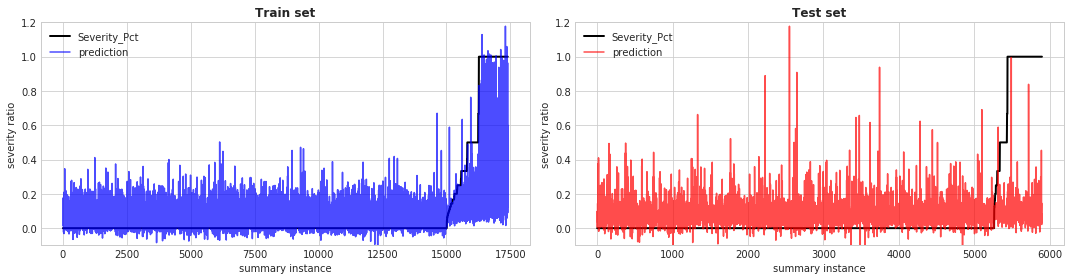

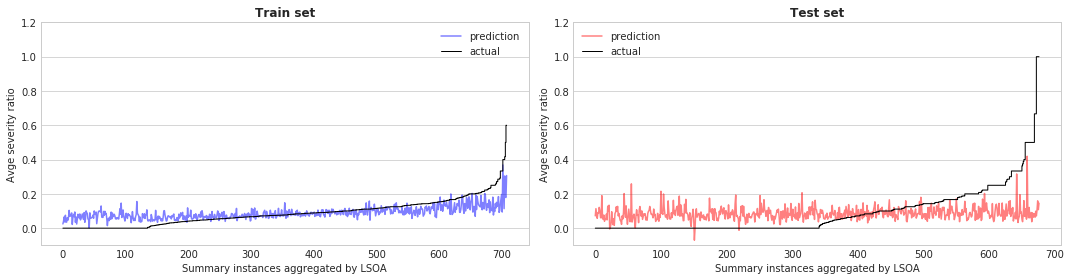

In [16]:
gbt_params={'maxIter':40, 'maxDepth':7, 'maxBins':100}
model_gbt_norm, rdd_train_norm, rdd_test_norm = train_model('Staffordshire', gbt_params, display_graph=True, cross_validated=False, save_figure=True)

=====>Analysing Bedfordshire police force data
loading and formatting data...
nb Slight:16149, nb Serious:2719, %Slight: 85.6%
Standard NA.drop only
Standard NA.drop only
loading completed  - Processing time: 25 secs
training start...
training completed  - Processing time: 634 secs
evaluation start...
Root Mean Squared Error (RMSE) on train data = 0.26
R2 (explained variance ratio) on train data = 0.37
evaluation completed  - Processing time: 7 secs
evaluation start...
Root Mean Squared Error (RMSE) on test data = 0.36
R2 (explained variance ratio) on test data = -0.09
evaluation completed  - Processing time: 4 secs
train set size=8652, test set size=2961
Saving figure Figure(1080x288)
Saving figure Figure(1080x288)


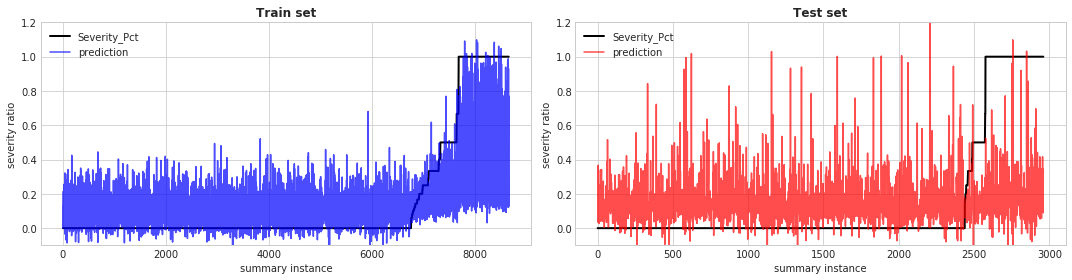

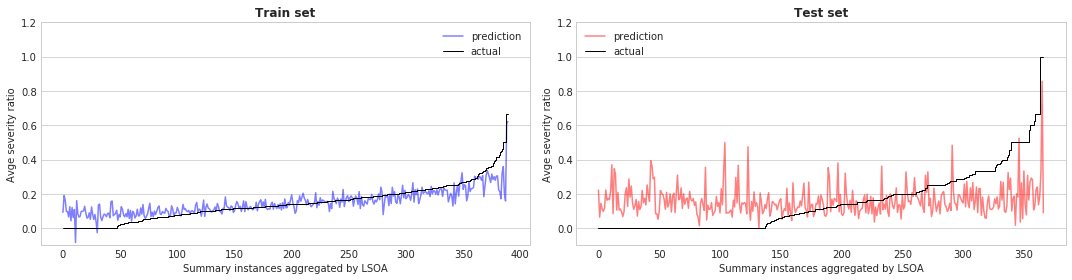

In [17]:
gbt_params={'maxIter':40, 'maxDepth':7, 'maxBins':100}
model_gbt_norm, rdd_train_norm, rdd_test_norm = train_model('Bedfordshire', gbt_params, display_graph=True, cross_validated=False, save_figure=True)